In [27]:
# torch with cuda
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from ultralytics import YOLO
import torch
import os

# Load a model
# model = YOLO("best.onnx")
yolo_model_s = YOLO("yolo11s.pt")
yolo_model_m = YOLO("yolo11m.pt")
# path = os.path.join(os.path.abspath("."),"License Plate Recognition.v6i.yolov11.zip")

# # Train the model
# train_results = model.train(
#     data=path,  # path to dataset YAML
#     epochs=100,  # number of training epochs
#     # workers=100,
#     # patience=100,
#     imgsz=640,  # training image size
#     device="cuda" if torch.cuda.is_available() else "cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
# )

# # Evaluate model performance on the validation set
# metrics = model.val()

# # Export the model to ONNX format
# path = model.export(format="onnx")  # return path to exported model

In [59]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from matplotlib import pyplot as plt
from safe_video import ObjectDetection, filter_results, merge_results_list
rec = ObjectDetection()

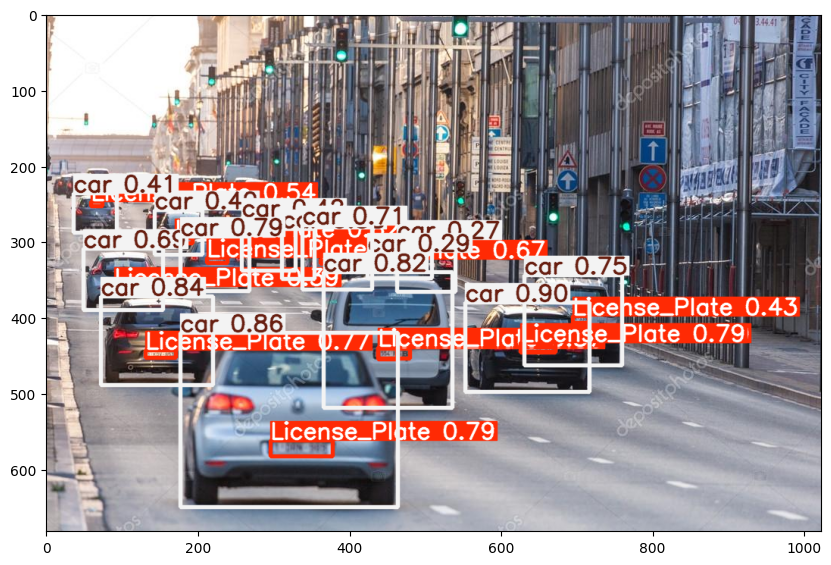

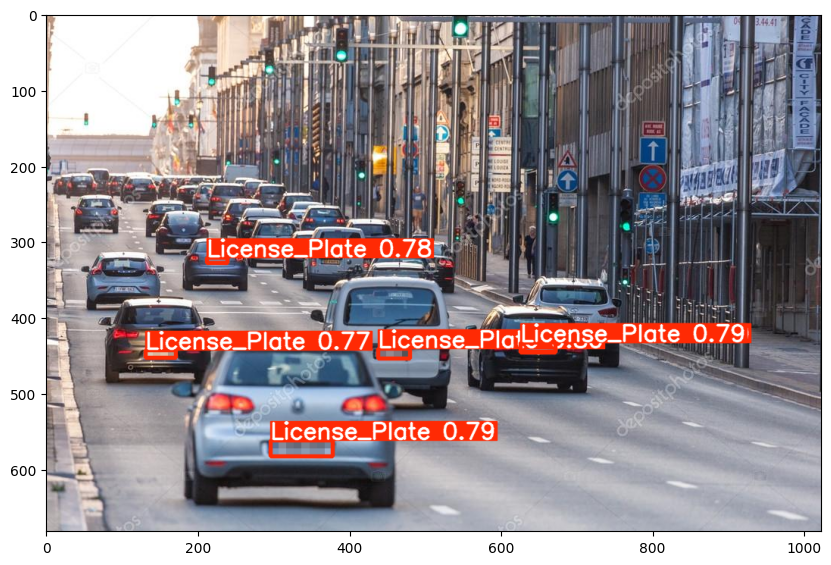

In [76]:
img_size = 10
image = plt.imread("example.jpg")
results = rec.process_image(image, ["car", "License_Plate"])
merged_results = merge_results_list(results)

plt.figure(figsize=(img_size,img_size))
plt.imshow(merged_results.plot())
plt.show()

# filters only for cars, after the the analysis
merged_results = filter_results(merged_results, "License_Plate", confidence_threshold=0.74)
blured = rec.apply_blur_to_image(image, merged_results)
merged_results.orig_img = blured
plt.figure(figsize=(img_size,img_size))
plt.imshow(merged_results.plot())
plt.show()

In [ ]:
video = r"video1.mp4"
rec.process_video(video, [['car','bus'],'License_Plate'], debug=True, verbose=False)